# **Spatio-temporal clustering for syndromic surveillance**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sb

In [2]:
# import cleaned and prepared data of consultations in RW
rw_data = pd.read_pickle("data/rw-cleaned-prepared-dynamic-data-phase1.pickle")

In [3]:
rw_data["PE214 - Blood oxygen saturation (%) - 8385"].unique()

array([nan, 'not_available', '95', '93', '100', '90', '99', '98', '97',
       '96', '94', '92', 95.0, 90.0, 96.0, 98.0, '91', 94.0, 97.0, '89',
       '78', 92.0, 91.0, 100.0, '87', '77', 99.0, '9', '42', '101',
       '96.8', '88', '80', '96.7', '97.2', 93.0, '97.4', '98.7', 96.8,
       '97.3', 96.5, '73', '83', '96.6', 101.0, '99.', '84', '50', '75',
       78.0, '76', '55', 84.0, '86', 89.0, '79', '85', '20', '74', '12',
       '32', '34', '54', '57', '30', 10.2, '70', '81', '64', '68', '82',
       '10', '96.5', '63', '61', '72', '92.9'], dtype=object)

# Data selection
Only pick columns relevant for the spatio-temporal clustering of symptoms. Relevant columns are:
1. time = "medical_case_consultation_date"
2. space
    - hf location = "health_facility_longitude" & "health_facility_latitude"
    - location of patient's home: "BD9 - Village (Umudugudu) - 8062" (cleaned in columns: ....)
3. demographic: 
    - age = "patient_birthdate"
    - sex = "patient_gender"
    - columns with BD in the beginning
    - columns with BM in the beginning
    - diagnosis (= potential labels for clusters) = columns with DF (, CH, A) in the beginning
4. symptoms = columns with CC, PE and (S, OS, A) in the beginning

Note:
- columns: District_Name, Sector_Name, Cell_Name, Village_Name contain the original village values extracted from the BD9...village.. column
- columns: best_match_village, best_match_cell, best_match_sector, best_match_district contain the best matching villages from the master lists
- columns: District, Sector, Cell, Village contain either the orignal village (if the village was correctly inputted in cdss) or the best matching village from the master list

In [4]:
columns_to_keep = [
    "medical_case_id",
    "medical_case_consultation_date_day",
    "patient_id",
    "patient_birthdate",
    "patient_gender",
    "health_facility_id",
    "health_facility_group_id",
    "health_facility_longitude",
    "health_facility_latitude",
    "health_facility_name",
    
]

demographic_columns = [
    "patient_id",
    "patient_age",
    "patient_gender"
]

spatio_temporal_columns = [
    "medical_case_consultation_date_day", # time
    "health_facility_name", "health_facility_longitude", "health_facility_latitude",  #spatial variant 1
    "District", "Sector", "Cell", "Village", "longitude_village", "latitude_village" #spatial variant 2
]

## Symptoms of interest
- Respiratory syndromes
    - S39...Cough...7817
    - PE214...Blood.oxygen.saturation.......8385.categorical
    - PE133...Grunting...8393
    - PE217...Severe.difficult.breathing.needing.referral...8398
- Convulsions/danger signs
    - S46...Convulsions.in.present.illness...8355
    - OS116...Convulsing.now...8356
    - CC33...Fever.or.convulsions.or.lethargy...7391
- Diarrhoeal/GI syndromes and danger signs
    - S64...Loose.or.liquid.stools..diarrhea....7647
    - S157...Vomiting.everything...8026
    - S96...Unable.to.drink.or.breastfeed...7871
- Fever and rash
    - S25...Fever.in.this.illness...7807
    - PE106...Non.specific.viral.rash...7930
    - PE158...Generalized.skin.rash...8033

In [5]:
symptoms_of_interest = ["S39 - Cough - 7817", 
    "PE214 - Blood oxygen saturation (%) - 8385", # should actually be "PE214 - Blood oxygen saturation (%) - 8385 categorical" according to domain experts
    "PE133 - Grunting - 8393", 
    "PE217 - Severe difficult breathing needing referral - 8398", 
    "S46 - Convulsions in present illness - 8355", 
    "OS116 - Convulsing now - 8356", 
    "CC33 - Fever or convulsions or lethargy - 7391", 
    "S64 - Loose or liquid stools (diarrhea) - 7647", 
    "S157 - Vomiting everything - 8026", 
    "S96 - Unable to drink or breastfeed - 7871", 
    "S25 - Fever in this illness - 7807", 
    "PE106 - Non specific viral rash - 7930", 
    "PE158 - Generalized skin rash - 8033"
]

In [6]:
# get symptom data
    # rw_symptoms = rw_data[[col for col in rw_data.columns if col[0:2] == "CC" or col[0:2] == "PE"]]

# get data of symptoms of interest


# select data for clustering
data = rw_data[np.concatenate((demographic_columns, symptoms_of_interest))]

In [7]:
# print list of columns used as features for clustering
for col in data.columns:
    print(col)

patient_id
patient_age
patient_gender
S39 - Cough - 7817
PE214 - Blood oxygen saturation (%) - 8385
PE133 - Grunting - 8393
PE217 - Severe difficult breathing needing referral - 8398
S46 - Convulsions in present illness - 8355
OS116 - Convulsing now - 8356
CC33 - Fever or convulsions or lethargy - 7391
S64 - Loose or liquid stools (diarrhea) - 7647
S157 - Vomiting everything - 8026
S96 - Unable to drink or breastfeed - 7871
S25 - Fever in this illness - 7807
PE106 - Non specific viral rash - 7930
PE158 - Generalized skin rash - 8033


# Data normalization
Convert binary string features to numerical binary features

In [8]:
# convert "patient_gender" column into numeric binary column
data["patient_gender"] = [1 if gender == "female" else 0 for gender in data["patient_gender"]]

# convert "yes"/"no" columns and "Absent"/"Present" columns to binary columns and 'not_available' values to np.nan
data = data.apply(lambda x : x.replace({"Yes": 1, "No": 0, "Absent": 0, "Present": 1, "not_available" : np.nan}), axis=1)

C:\Users\sidla\AppData\Local\Temp\ipykernel_15912\2503329619.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["patient_gender"] = [1 if gender == "female" else 0 for gender in data["patient_gender"]]


In [9]:
# convert all features to numbers
data = data.astype(float)

# Quality control of selected data for clustering

## Low variance

In [10]:
description_data = data.describe() # note: per default NaN values excluded
description_data 

patient_id   patient_age  patient_gender  S39 - Cough - 7817  \
count  47886.000000  47886.000000    47886.000000        32055.000000   
mean   38476.352003      3.268868        0.527628            0.551053   
std    17358.442155      3.549796        0.499241            0.497395   
min        6.000000      0.000000        0.000000            0.000000   
25%    24655.250000      0.000000        0.000000            0.000000   
50%    41355.000000      2.000000        1.000000            1.000000   
75%    53114.750000      5.000000        1.000000            1.000000   
max    64783.000000     15.000000        1.000000            1.000000   

       PE214 - Blood oxygen saturation (%) - 8385  PE133 - Grunting - 8393  \
count                                 5066.000000              1945.000000   
mean                                    95.280932                 0.064267   
std                                      4.951684                 0.245292   
min                                      9.000000                 0.000000   
25%                                     95.000000                 0.000000   
50%                                     96.000000                 0.000000   
75%                                     98.000000                 0.000000   
max                                    101.000000                 1.000000   

       PE217 - Severe difficult breathing needing referral - 8398  \
count                                        1945.000000            
mean                                            0.027249            
std                                             0.162851            
min                                             0.000000            
25%                                             0.000000            
50%                                             0.000000            
75%                                             0.000000            
max                                             1.000000            

       S46 - Convulsions in present illness - 8355  \
count                                 32943.000000   
mean                                      0.001214   
std                                       0.034825   
min                                       0.000000   
25%                                       0.000000   
50%                                       0.000000   
75%                                       0.000000   
max                                       1.000000   

       OS116 - Convulsing now - 8356  \
count                   32963.000000   
mean                        0.000819   
std                         0.028609   
min                         0.000000   
25%                         0.000000   
50%                         0.000000   
75%                         0.000000   
max                         1.000000   

       CC33 - Fever or convulsions or lethargy - 7391  \
count                                    47886.000000   
mean                                         0.002464   
std                                          0.049580   
min                                          0.000000   
25%                                          0.000000   
50%                                          0.000000   
75%                                          0.000000   
max                                          1.000000   

       S64 - Loose or liquid stools (diarrhea) - 7647  \
count                                    32204.000000   
mean                                         0.125574   
std                                          0.331374   
min                                          0.000000   
25%                                          0.000000   
50%                                          0.000000   
75%                                          0.000000   
max                                          1.000000   

       S157 - Vomiting everything - 8026  \
count                       31562.000000   
mean                            0.007667   
std               

In [11]:
# check for low variance columns
low_var_threshold = 10 # NOTE does not make sense for binary features which make up the majority in this dataset
var_rw_data = description_data.loc[["std"]].transpose().dropna().sort_values(by=["std"])
var_rw_data

std
OS116 - Convulsing now - 8356                           0.028609
S46 - Convulsions in present illness - 8355             0.034825
CC33 - Fever or convulsions or lethargy - 7391          0.049580
S96 - Unable to drink or breastfeed - 7871              0.052130
S157 - Vomiting everything - 8026                       0.087229
PE217 - Severe difficult breathing needing refe...      0.162851
PE133 - Grunting - 8393                                 0.245292
S64 - Loose or liquid stools (diarrhea) - 7647          0.331374
PE106 - Non specific viral rash - 7930                  0.436719
S25 - Fever in this illness - 7807                      0.476529
PE158 - Generalized skin rash - 8033                    0.482850
S39 - Cough - 7817                                      0.497395
patient_gender                                          0.499241
patient_age                                             3.549796
PE214 - Blood oxygen saturation (%) - 8385              4.951684
patient_id                                          17358.442155

<AxesSubplot:title={'center':'Low variance columns'}>

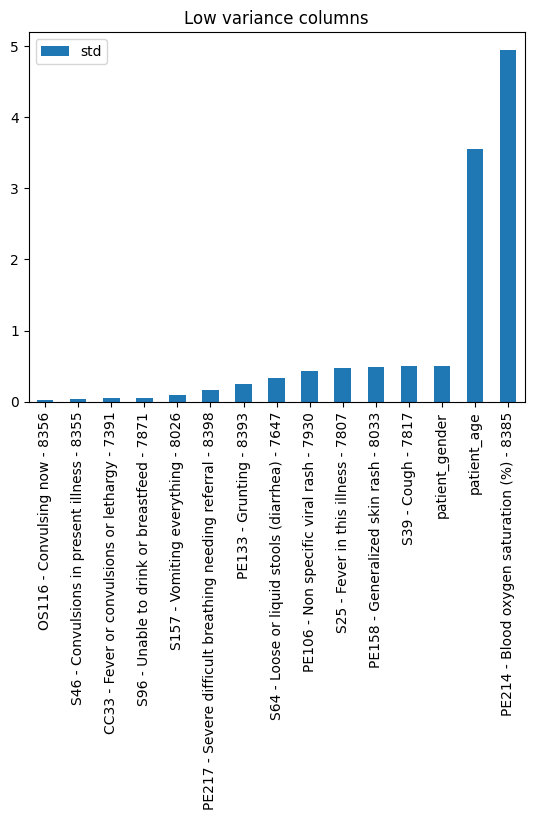

In [12]:
# plot low variance columns
var_rw_data[var_rw_data["std"] <= low_var_threshold].plot(kind="bar", rot=90, title="Low variance columns")

### "Low variance" in binary columns

In [13]:
# get binary features
binary_features_names = data.nunique(dropna=True).loc[lambda x : x <= 2].index
binary_data = data[binary_features_names]

# count 1s and NaN values in each binary column
summary_binary_features = pd.DataFrame({"count_1s" : binary_data.sum(), "count_nan" : (binary_data.isna()*1).sum()})
summary_binary_features["n"] = binary_data.shape[0] #add number of observations for each feature (including nan)
summary_binary_features["share_1s"] = summary_binary_features["count_1s"] / (summary_binary_features["n"] - summary_binary_features["count_nan"])
summary_binary_features

count_1s  count_nan  \
patient_gender                                       25266.0          0   
S39 - Cough - 7817                                   17664.0      15831   
PE133 - Grunting - 8393                                125.0      45941   
PE217 - Severe difficult breathing needing refe...      53.0      45941   
S46 - Convulsions in present illness - 8355             40.0      14943   
OS116 - Convulsing now - 8356                           27.0      14923   
CC33 - Fever or convulsions or lethargy - 7391         118.0          0   
S64 - Loose or liquid stools (diarrhea) - 7647        4044.0      15682   
S157 - Vomiting everything - 8026                      242.0      16324   
S96 - Unable to drink or breastfeed - 7871              86.0      16325   
S25 - Fever in this illness - 7807                   11498.0      14901   
PE106 - Non specific viral rash - 7930                 447.0      46142   
PE158 - Generalized skin rash - 8033                  1760.0      43129   

                                                        n  share_1s  
patient_gender                                      47886  0.527628  
S39 - Cough - 7817                                  47886  0.551053  
PE133 - Grunting - 8393                             47886  0.064267  
PE217 - Severe difficult breathing needing refe...  47886  0.027249  
S46 - Convulsions in present illness - 8355         47886  0.001214  
OS116 - Convulsing now - 8356                       47886  0.000819  
CC33 - Fever or convulsions or lethargy - 7391      47886  0.002464  
S64 - Loose or liquid stools (diarrhea) - 7647      47886  0.125574  
S157 - Vomiting everything - 8026                   47886  0.007667  
S96 - Unable to drink or breastfeed - 7871          47886  0.002725  
S25 - Fever in this illness - 7807                  47886  0.348583  
PE106 - Non specific viral rash - 7930              47886  0.256307  
PE158 - Generalized skin rash - 8033                47886  0.369981

## Missingness

In [14]:
# share of nan per feature
nnan_data = data.isnull().sum(axis = 0).to_frame(name="nnan").sort_values("nnan", ascending=False)
nnan_data["nnan_share_in_%"] = nnan_data["nnan"] / data.shape[0] * 100
nnan_data

nnan  nnan_share_in_%
PE106 - Non specific viral rash - 7930              46142        96.358017
PE133 - Grunting - 8393                             45941        95.938270
PE217 - Severe difficult breathing needing refe...  45941        95.938270
PE158 - Generalized skin rash - 8033                43129        90.065990
PE214 - Blood oxygen saturation (%) - 8385          42820        89.420708
S96 - Unable to drink or breastfeed - 7871          16325        34.091384
S157 - Vomiting everything - 8026                   16324        34.089295
S39 - Cough - 7817                                  15831        33.059767
S64 - Loose or liquid stools (diarrhea) - 7647      15682        32.748611
S46 - Convulsions in present illness - 8355         14943        31.205363
OS116 - Convulsing now - 8356                       14923        31.163597
S25 - Fever in this illness - 7807                  14901        31.117654
patient_id                                              0         0.000000
patient_age                                             0         0.000000
patient_gender                                          0         0.000000
CC33 - Fever or convulsions or lethargy - 7391          0         0.000000

NAN share category (in %)
(-0.001, 1.0]    4
(1.0, 10.0]      0
(10.0, 20.0]     0
(20.0, 30.0]     0
(30.0, 40.0]     7
(40.0, 50.0]     0
(50.0, 60.0]     0
(60.0, 70.0]     0
(70.0, 80.0]     0
(80.0, 90.0]     1
(90.0, 100.0]    4
dtype: int64


<AxesSubplot:title={'center':'Number of features per NAN category'}, xlabel='NAN share category (in %)'>

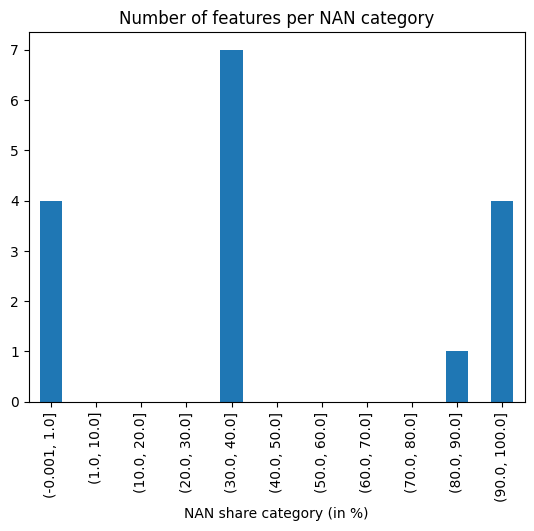

In [15]:
# count groups for each nnan share category
nnan_data["nnan_share_in_%"] = nnan_data["nnan"] / data.shape[0] * 100
nnan_data["NAN share category (in %)"] = pd.cut(nnan_data["nnan_share_in_%"], bins=[0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], right=True, include_lowest=True)
print(nnan_data.groupby("NAN share category (in %)").size())
nnan_data.groupby("NAN share category (in %)").size().plot(kind="bar", title="Number of features per NAN category")

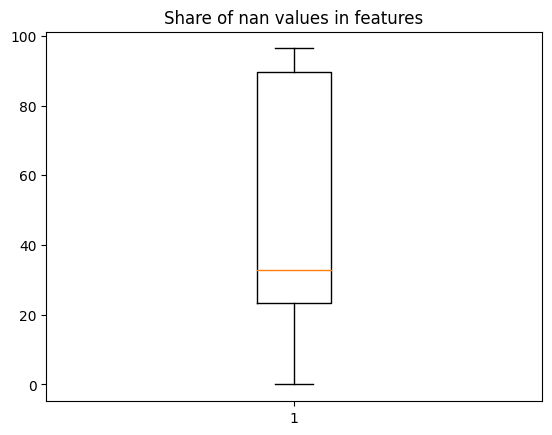

In [16]:
# boxplot of share of nan values in feautures
plt.boxplot(nnan_data["nnan_share_in_%"])
plt.title("Share of nan values in features")
plt.show()

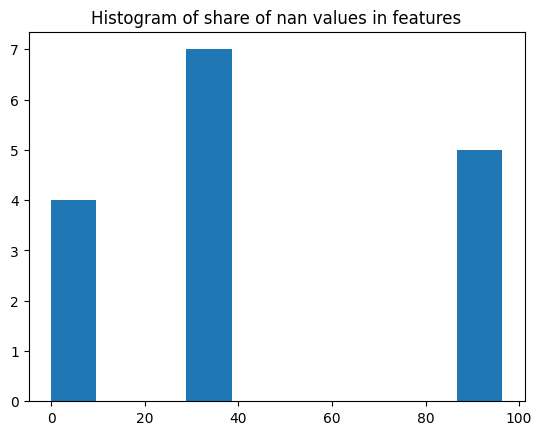

In [17]:
# distribution of share of nan values in features
plt.hist(nnan_data["nnan_share_in_%"])
plt.title("Histogram of share of nan values in features")
plt.show()

In [18]:
# columns with no nan
print(nnan_data[nnan_data["nnan"] == 0].size/nnan_data.size*100, "%", "of columns contain no NaN values!")
nnan_data[nnan_data["nnan"] == 0].index

25.0 % of columns contain no NaN values!


Index(['patient_id', 'patient_age', 'patient_gender',
       'CC33 - Fever or convulsions or lethargy - 7391'],
      dtype='object')

100.0 % of columns contain less or equal than 100 % of NaN values!


<AxesSubplot:title={'center':'Columns with less or equal than 100% of NaN values'}>

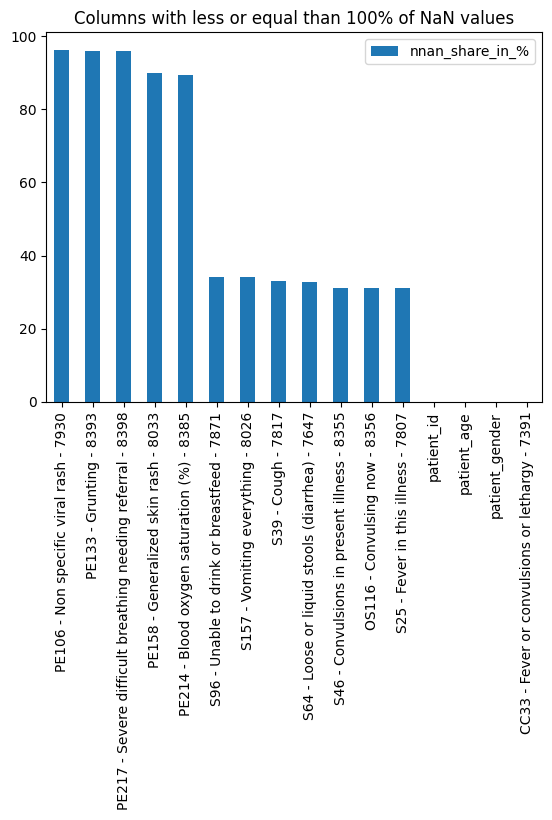

In [19]:
# plot columns with too many NaN values
nnan_threshold = 100 # in % (NOTE: all features with more than nnan_threshold nan values will be removed in data cleaning section)
print(nnan_data[nnan_data["nnan_share_in_%"] <= nnan_threshold].shape[0] / nnan_data.shape[0] * 100, "%", "of columns contain less or equal than", nnan_threshold,"%", "of NaN values!")
nnan_data[nnan_data["nnan_share_in_%"]  <= nnan_threshold].plot(kind="bar", y="nnan_share_in_%", rot=90, title=f"Columns with less or equal than {nnan_threshold}% of NaN values")

# Data Cleaning

In [20]:
# drop columns with too many NaN values based on nnan_threshold and store them as features
features = data[nnan_data[nnan_data["nnan_share_in_%"]  <= nnan_threshold].index]


# print number of final features and how many nan values they contain
print("number of final features:", len(features.columns))
print("number of dropped features:", len(data.columns) - len(features.columns))
print("total amount of nan values accross features:", features.isna().sum().sum())

# print list of columns dropped because of this cleaning step
print("columns used as features:", features.columns)

number of final features: 16
number of dropped features: 0
total amount of nan values accross features: 332902
columns used as features: Index(['PE106 - Non specific viral rash - 7930', 'PE133 - Grunting - 8393',
       'PE217 - Severe difficult breathing needing referral - 8398',
       'PE158 - Generalized skin rash - 8033',
       'PE214 - Blood oxygen saturation (%) - 8385',
       'S96 - Unable to drink or breastfeed - 7871',
       'S157 - Vomiting everything - 8026', 'S39 - Cough - 7817',
       'S64 - Loose or liquid stools (diarrhea) - 7647',
       'S46 - Convulsions in present illness - 8355',
       'OS116 - Convulsing now - 8356', 'S25 - Fever in this illness - 7807',
       'patient_id', 'patient_age', 'patient_gender',
       'CC33 - Fever or convulsions or lethargy - 7391'],
      dtype='object')


# Missingness pattern in features - MCAR, MAR or MNAR?
- MCAR = Missing completely at random = missingness of values of a certain feature depends not on any data
- MAR = Missing at random = missingness of values of a certain feature depends on given values of other features (e.g. symptom1 is missing data when there are high values of symptom2 given.)
- MNAR = Missing not at random = missingness of values of a certain feature depends the not given data of the feature itself (e. g. symptom1 misses data whenever symptom1 would have low values. However, these low values are never observed.)

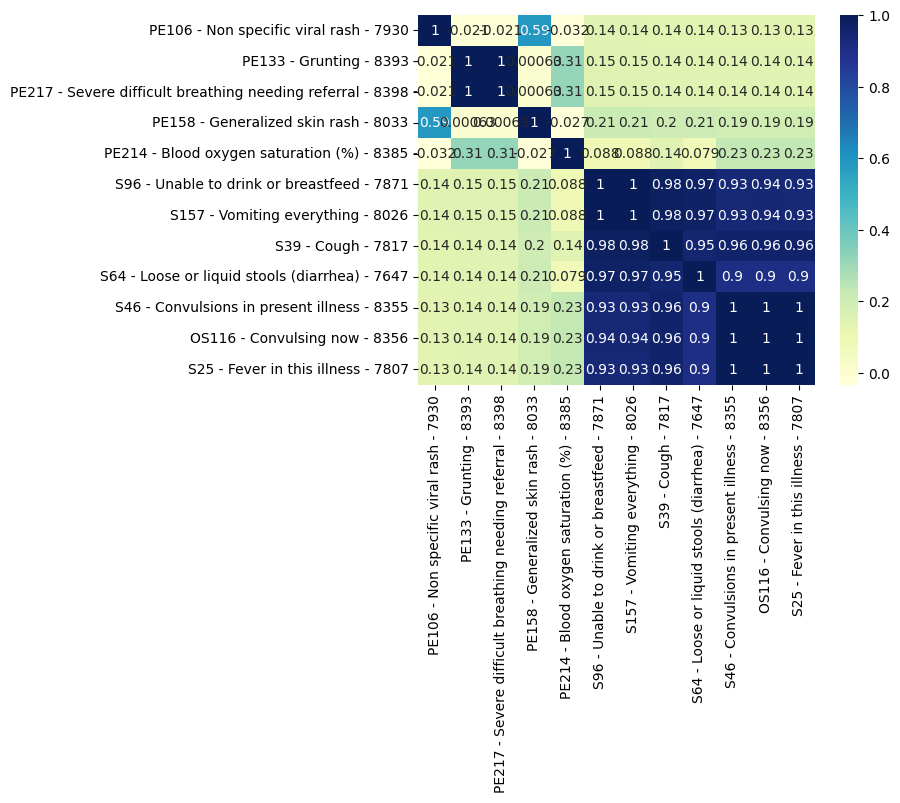

In [21]:
# shadow matrix: whenever original features holds nan value the missingness matrix will have a 1 at this element position else 0
shadow_matrix = features.isna()*1

# check if missingness of features correlates with other features' missingness
missingness_correlation = shadow_matrix.corr().dropna(how = "all").dropna(how = "all", axis = 1) # drop rows and columns which entirely consist of nan

# visualize correlation of features' missingness
missingness_correlation_heatmap = sb.heatmap(missingness_correlation, cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

In [22]:
# categorize featuers' correlation into very strong (1-0.9), strong (0.9-0.7), high (0.7-0.5), medium (0.5-0.3), low (0.3-0.1), very low (0.1-0)
categorized_missingness_correlation = missingness_correlation
categorized_missingness_correlation
# TODO

PE106 - Non specific viral rash - 7930  \
PE106 - Non specific viral rash - 7930                                            1.000000   
PE133 - Grunting - 8393                                                          -0.020802   
PE217 - Severe difficult breathing needing refe...                               -0.020802   
PE158 - Generalized skin rash - 8033                                              0.585387   
PE214 - Blood oxygen saturation (%) - 8385                                       -0.032439   
S96 - Unable to drink or breastfeed - 7871                                        0.139822   
S157 - Vomiting everything - 8026                                                 0.139816   
S39 - Cough - 7817                                                                0.136625   
S64 - Loose or liquid stools (diarrhea) - 7647                                    0.135666   
S46 - Convulsions in present illness - 8355                                       0.130937   
OS116 - Convulsing now - 8356                                                     0.130810   
S25 - Fever in this illness - 7807                                                0.130670   

                                                    PE133 - Grunting - 8393  \
PE106 - Non specific viral rash - 7930                            -0.020802   
PE133 - Grunting - 8393                                            1.000000   
PE217 - Severe difficult breathing needing refe...                 1.000000   
PE158 - Generalized skin rash - 8033                               0.000631   
PE214 - Blood oxygen saturation (%) - 8385                         0.314448   
S96 - Unable to drink or breastfeed - 7871                         0.147983   
S157 - Vomiting everything - 8026                                  0.147976   
S39 - Cough - 7817                                                 0.144599   
S64 - Loose or liquid stools (diarrhea) - 7647                     0.143584   
S46 - Convulsions in present illness - 8355                        0.137437   
OS116 - Convulsing now - 8356                                      0.138444   
S25 - Fever in this illness - 7807                                 0.138296   

                                                    PE217 - Severe difficult breathing needing referral - 8398  \
PE106 - Non specific viral rash - 7930                                                      -0.020802            
PE133 - Grunting - 8393                                                                      1.000000            
PE217 - Severe difficult breathing needing refe...                                           1.000000            
PE158 - Generalized skin rash - 8033                                                         0.000631            
PE214 - Blood oxygen saturation (%) - 8385                                                   0.314448            
S96 - Unable to drink or breastfeed - 7871                                                   0.147983            
S157 - Vomiting everything - 8026                                                            0.147976            
S39 - Cough - 7817                                                                           0.144599            
S64 - Loose or liquid stools (diarrhea) - 7647                                               0.143584            
S46 - Convulsions in present illness - 8355                                                  0.137437            
OS116 - Convulsing now - 8356                                                                0.138444            
S25 - Fever in this illness - 7807                                                           0.138296            

                                                    PE158 - Generalized skin rash - 8033  \
PE106 - Non specific viral rash - 7930                                          0.585387   
PE133 - Grunting - 8393                                                         0.000631   
PE217 - Severe difficult breathing needing

There are several correlations among the features's missingness. One example would be `PE217 - Severe difficult breathing needing referral - 8398` and `PE133 - Grunting - 8393` with a correlation coefficient of 1, meaning that whenever data is missing for one feature the other feature misses data too. This is an indicator for missing at random because missingness of a feature can be explained by the given data of another feature. 

# Clustering
In the following the previously selected and cleaned features are clustered. Since the underlying data comes from CDSS, a lot of NAN values are systematically present. To address this, there will be diverse clustering runs:
1. K-Means clustering of raw features with NAN values Mahalanobis distance
2. K-Means clustering of the features containing no NAN values
3. K-Means clustering of all features with imputed values (mean for continues features and median for categorical features)
4. K-Means clustering of all features with imputed values and additional binary feature to track the imputed values for each feature

Please note, that K-Means is chosen for clustering whenever applicable due to experience from previous work on clustering CDSS data at IGH. 
    

cluster three datasets different regarding how missingness is addressed
        1. symptom and demographic data with NAN values --> use kmeans variation that handles NAN (kmeans++ or fuzzy clustering or GMM)
        2. impute NAN as if missingness is at random: use mean for continues and median for binary
        3. impute NAN as above. however, we also always add a binary column keeping track if value of respective feature is imputed or not --> analyse if imputation is picked up by clusters

In [24]:
!pip install yellowbrick


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

## Clustering of raw features (with NAN values)
Mahalanobis distance is used since it can handle NAN values. It is defined as the distance between two points, x and y, in a multivariate space, normalized by the variance-covariance matrix of the dataset, i. e. it is the Euclidian distance weighted by the inverse of the variance-covariance matrix. This means that features that have a high variance (i.e., that are more spread out) will have less weight in the distance computation than variables with low variance.

In [26]:
if False: 
    from sklearn.covariance import EmpiricalCovariance
    from sklearn.metrics.pairwise import pairwise_distances

    # Compute the covariance matrix using the available data
    cov = EmpiricalCovariance().fit(features[np.isfinite(features).all(axis=1)])

    # Compute the Mahalanobis distance matrix using the covariance matrix
    mahalanobis_dist = pairwise_distances(features, metric='mahalanobis', VI=np.linalg.inv(cov.covariance_))

    # Perform k-means clustering with k=3
    kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
    kmeans.fit(mahalanobis_dist)

    # Print cluster assignments for each observation
    print(kmeans.labels_)

In [27]:
if False:
    #  TODO try out kmeans with Gower distance or the Mahalanobis distance
    from sklearn.metrics.pairwise import pairwise_distances


    # Compute Gower distances
    gower_dist = pairwise_distances(features, metric='mahalanobis')
    print(gower_dist.shape)

    # Perform k-means clustering with k=3
    kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
    kmeans.fit(gower_dist)

    # Print cluster assignments for each observation
    print(features.shape)
    print(kmeans.labels_)

In [28]:
if False:
    !pip install scikit-learn-extra

In [29]:
if False:
    from sklearn_extra.cluster import KMedoids

    # Finding the optimal number of clusters using the Elbow method with yellowbrick
    model = KMedoids(n_init =10)
    visualizer = KElbowVisualizer(model, k=(1,11))
    visualizer.fit(features)
    n_clusters = visualizer.elbow_value_ # optimal number of clusters
    visualizer.show()

In [30]:
if False:
    # Performing clustering with the optimal number of clusters
    kmoids = KMedoids(n_clusters=n_clusters, n_init=10, random_state=0).fit(features)

    # Adding the column 'cluster' to the dataframe
    features_raw = features
    features_raw["cluster"] = kmoids.labels_

In [31]:
if False:
    !pip install kmodes

In [32]:
if False:
    # Initialize the KModes algorithm with 3 clusters and let it automatically detect categorical features
    kmodes = KModes(n_clusters=3)
    clusters = kmodes.fit_predict(features, categorical=None, missing='value')

    # Get the cluster centroids and the column indices of the categorical features
    centroids = kmodes.cluster_centroids_
    cat_cols = np.unique(np.where(np.isnan(centroids))[1])

In [33]:
if False:
    from kmodes.kprototypes import KPrototypes
    from kmodes.kmodes import KModes

    # Compute the  within-cluster sum of squaresWCSS for different numbers of clusters
    # TODO filter for "nan" in the doc https://kprototypes.readthedocs.io/_/downloads/en/latest/pdf/
    wcss = []
    for i in range(1, 11):
        kproto = KPrototypes(n_clusters=i) #, categorical=cat_cols
        kproto.fit(features, missing='value')
        wcss.append(kproto.cost_)

    # Plot the WCSS results
    plt.plot(range(1, 11), wcss)
    plt.title("Elbow Method")
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

## K-Means clustering of the features containing no NAN values

In [34]:
# Retrieve all features with no nan value
features_no_nan = features.dropna(axis=1)
print("Dropping columns with NAN, leads to", features.shape[1]-features_no_nan.shape[1],"less columns.")
print(features_no_nan.shape[1], "columns are used for clustering, which are:")
for col in features_no_nan.columns:
    print(col)

Dropping columns with NAN, leads to 12 less columns.
4 columns are used for clustering, which are:
patient_id
patient_age
patient_gender
CC33 - Fever or convulsions or lethargy - 7391


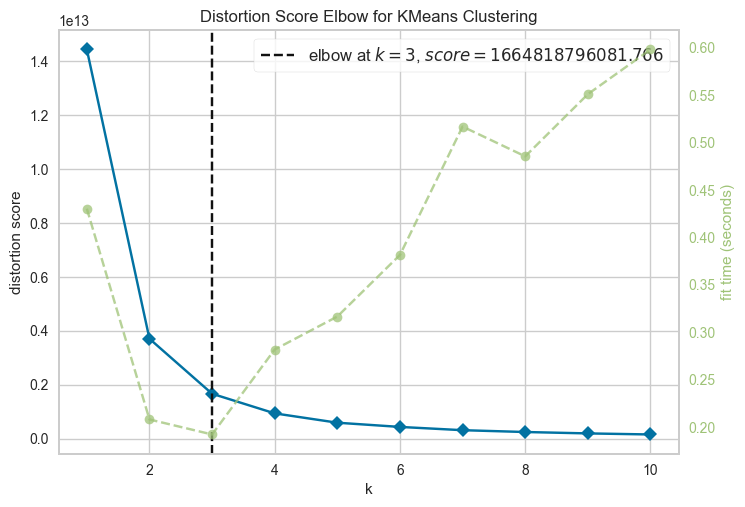

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [35]:
# Finding the optimal number of clusters using the Elbow method with yellowbrick
model = KMeans(n_init =10)
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(features_no_nan)
n_clusters = visualizer.elbow_value_ # optimal number of clusters
visualizer.show()

In [36]:
# Performing clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0).fit(features_no_nan)

# Adding the column 'cluster' to the dataframe
features_no_nan["cluster"] = kmeans.labels_

C:\Users\sidla\AppData\Local\Temp\ipykernel_15912\3283319560.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_no_nan["cluster"] = kmeans.labels_


<AxesSubplot:title={'center':'Number of consultations per cluster'}, xlabel='cluster'>

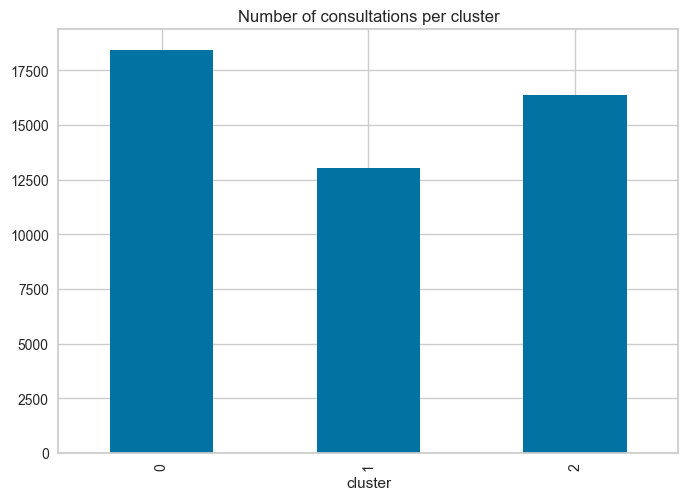

In [37]:
features_no_nan.groupby("cluster").size().plot(kind="bar", title="Number of consultations per cluster")

## K-Means with imputed features

In [38]:
imputed_features = features.copy(deep=True)

In [39]:
# impute binary columns with median
for binary_col in imputed_features.nunique(dropna=True).loc[lambda x : x <= 2].index:
    imputed_features[binary_col].fillna(imputed_features[binary_col].median(), inplace=True)

In [40]:
# impute continues variables with mean
# NOTE we assume all remaining features with NaN are not binary and thus continues
for nan_col in (imputed_features.isna()*1).sum().loc[lambda x : x != 0].index:
    imputed_features[nan_col].fillna(imputed_features[nan_col].mean(), inplace=True)

In [41]:
print("Before imputation:", features.isna().sum().sum(), "NAN values in", features.isna().sum().loc[features.isna().sum()>0].shape[0],"columns")
print("After imputation:", imputed_features.isna().sum().sum(), "NAN values in", imputed_features.isna().sum().loc[imputed_features.isna().sum()>0].shape[0],"columns")

Before imputation: 332902 NAN values in 12 columns
After imputation: 0 NAN values in 0 columns


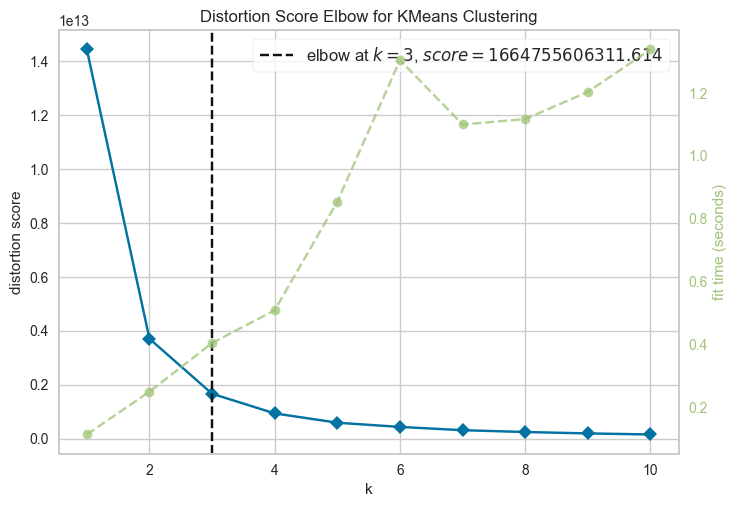

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [42]:
# Finding the optimal number of clusters using the Elbow method with yellowbrick
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(imputed_features)
n_clusters = visualizer.elbow_value_ # optimal number of clusters
visualizer.show()

In [43]:
# Performing clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0).fit(imputed_features)

# Adding the column 'cluster' to the dataframe
imputed_features["cluster"] = kmeans.labels_

<AxesSubplot:title={'center':'Number of consultations per cluster'}, xlabel='cluster'>

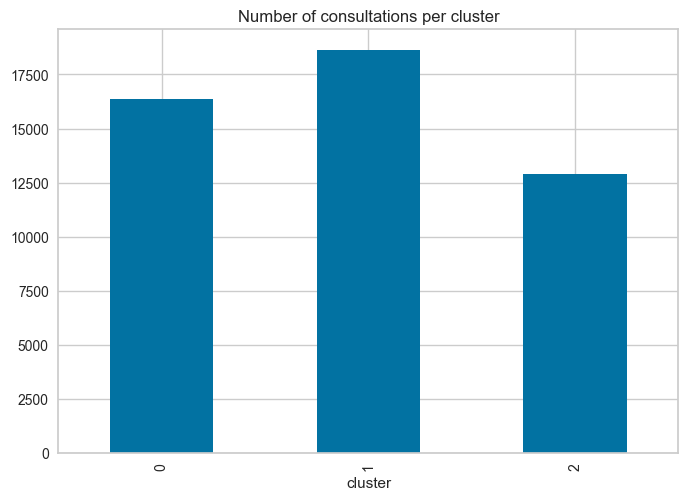

In [44]:
imputed_features.groupby("cluster").size().plot(kind="bar", title="Number of consultations per cluster")

## K-Means clustering with imputed features and feature augmentation

In [45]:
augmented_imputed_features = features.copy(deep=True)

In [46]:
# impute binary columns with median
for binary_col in augmented_imputed_features.nunique(dropna=True).loc[lambda x : x <= 2].index:
    if augmented_imputed_features[binary_col].isna().sum() == 0:
        continue
    augmented_imputed_features["imputed_"+binary_col] = np.multiply(augmented_imputed_features[binary_col].isna(), 1)
    augmented_imputed_features[binary_col].fillna(augmented_imputed_features[binary_col].median(), inplace=True)


In [47]:
# impute continues variables with mean
# NOTE we assume all remaining columns are not binary and thus continues
for nan_col in augmented_imputed_features.isna().sum().loc[lambda x : x != 0].index:
    augmented_imputed_features["imputed_"+nan_col] = np.multiply(augmented_imputed_features[nan_col].isna(), 1)
    augmented_imputed_features[nan_col].fillna(augmented_imputed_features[nan_col].mean(), inplace=True)

In [48]:
print("Before imputation:", features.isna().sum().sum(), "NAN values in", features.isna().sum().loc[features.isna().sum()>0].shape[0],"columns")
print("After imputation:", augmented_imputed_features.isna().sum().sum(), "NAN values in", augmented_imputed_features.isna().sum().loc[augmented_imputed_features.isna().sum()>0].shape[0],"columns")

Before imputation: 332902 NAN values in 12 columns
After imputation: 0 NAN values in 0 columns


In [49]:
augmented_imputed_features.columns

Index(['PE106 - Non specific viral rash - 7930', 'PE133 - Grunting - 8393',
       'PE217 - Severe difficult breathing needing referral - 8398',
       'PE158 - Generalized skin rash - 8033',
       'PE214 - Blood oxygen saturation (%) - 8385',
       'S96 - Unable to drink or breastfeed - 7871',
       'S157 - Vomiting everything - 8026', 'S39 - Cough - 7817',
       'S64 - Loose or liquid stools (diarrhea) - 7647',
       'S46 - Convulsions in present illness - 8355',
       'OS116 - Convulsing now - 8356', 'S25 - Fever in this illness - 7807',
       'patient_id', 'patient_age', 'patient_gender',
       'CC33 - Fever or convulsions or lethargy - 7391',
       'imputed_PE106 - Non specific viral rash - 7930',
       'imputed_PE133 - Grunting - 8393',
       'imputed_PE217 - Severe difficult breathing needing referral - 8398',
       'imputed_PE158 - Generalized skin rash - 8033',
       'imputed_S96 - Unable to drink or breastfeed - 7871',
       'imputed_S157 - Vomiting everything -

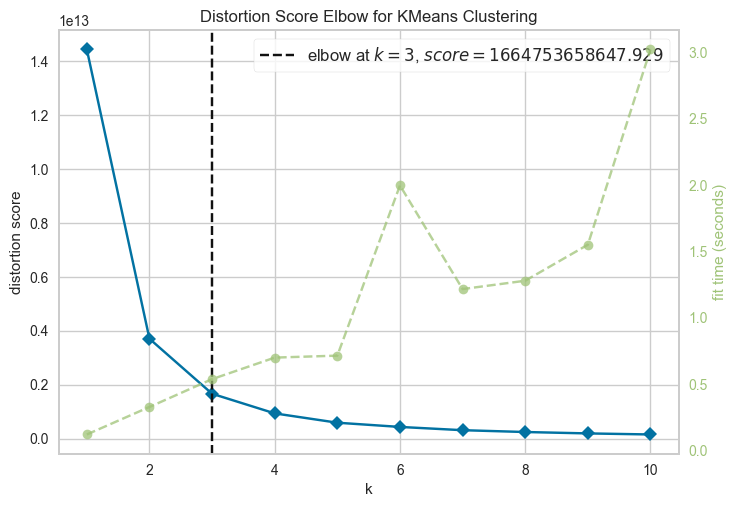

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [50]:
# Finding the optimal number of clusters using the Elbow method with yellowbrick
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(1,11))
visualizer.fit(augmented_imputed_features)
n_clusters = visualizer.elbow_value_ # optimal number of clusters
visualizer.show()

In [51]:
# Performing clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0).fit(augmented_imputed_features)

# Adding the column 'cluster' to the dataframe
augmented_imputed_features["cluster"] = kmeans.labels_

<AxesSubplot:title={'center':'Number of consultations per cluster'}, xlabel='cluster'>

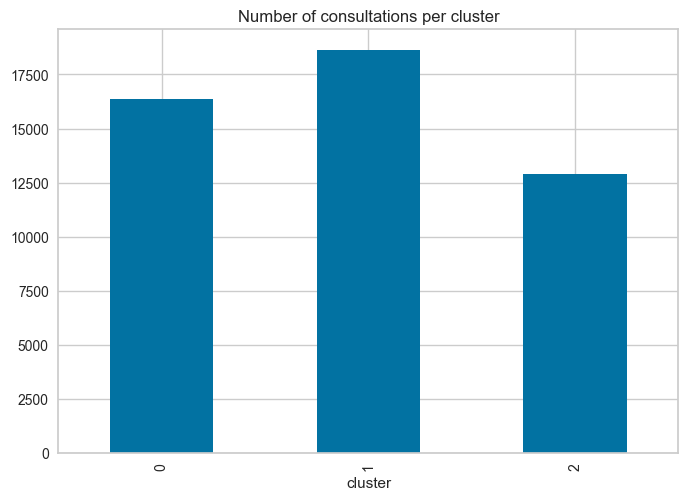

In [52]:
augmented_imputed_features.groupby("cluster").size().plot(kind="bar", title="Number of consultations per cluster")

# Quality check up of clusters

In [53]:
# bundling of all clustering methods' result
cluster_datasets = [features_no_nan, imputed_features, augmented_imputed_features]

## Silhouette score

In [54]:
from sklearn.metrics import silhouette_score
for i, cluster_data in enumerate(cluster_datasets):
    if i == 0:
        print("clustering with no nan values")
    elif i == 1:
        print("clustering with imputed values")
    else:
        print("clustering with imputed values and extra binary column tracking imputation")
    
    features = cluster_data[cluster_data.columns[~cluster_data.columns.isin(["cluster"])]]
    silhouette_avg = silhouette_score(features, cluster_data["cluster"])
    print("The average Silhouette score is :", silhouette_avg)

clustering with no nan values
The average Silhouette score is : 0.5859990608981679
clustering with imputed values
The average Silhouette score is : 0.5857800930593137
clustering with imputed values and extra binary column tracking imputation
The average Silhouette score is : 0.5857841509494099


The Silhouette score is a metric that measures how well a data point fits into its assigned cluster, as compared to other clusters. It takes values between -1 and 1, where:

- A score of +1 indicates that the data point is far away from its neighboring clusters and is well-matched to its assigned cluster.
- A score of 0 indicates that the data point is close to the decision boundary between two clusters.
- A score of -1 indicates that the data point may have been assigned to the wrong cluster.

The Silhouette score can be used to evaluate the quality of a clustering solution, with higher scores indicating better cluster quality. However, it should be noted that a high Silhouette score does not necessarily mean that the clustering solution is optimal, as there may be other solutions with equally good or better scores. 

That being said, all clustering methods do not seem to differentiate each other by much in terms of the silhouette score. They all have a average silhouette score that is slightly below 0.5 which is generally the lower-bound for silhouette scores of acceptable clusterings.

## Robustness
1. Bootstrap resampling: This involves randomly resampling the original dataset with replacement to create multiple bootstrap samples. Clustering is then performed on each of these samples, and the resulting clusters are compared to see how stable they are across the different samples. If the clustering solution is robust, the resulting clusters should be similar across the different bootstrap samples.

2. K-fold cross-validation: This involves splitting the original dataset into k equal-sized folds, and then performing clustering on k-1 folds and evaluating the resulting clusters on the remaining fold. This process is repeated k times, with each fold serving as the test set once. The resulting clusters are then compared across the different iterations to see how stable they are. If the clustering solution is robust, the resulting clusters should be similar across the different folds.

3. Sensitivity analysis: This involves varying the parameters of the clustering algorithm (such as the number of clusters or the distance metric) and evaluating the resulting clusters. If the clustering solution is robust, the resulting clusters should be relatively stable across different parameter values.

4. Visual inspection: This involves visually inspecting the resulting clusters and looking for any patterns or outliers that may indicate problems with the clustering solution. For example, if there are a few data points that consistently get assigned to different clusters across different runs of the clustering algorithm, this may indicate a problem with the clustering solution.

In [55]:
# TODO

## Effect of missingness on clustering

In [56]:
# shadow matrix: whenever original features holds nan value the missingness matrix will have a 1 at this element position else 0
 #shadow_matrix = features.isna()*1

In [57]:
from sklearn.linear_model import LogisticRegression

# perform logistic regression on missingness_matrix with output being the labels of all clustering methods' result
for i, cluster_data in enumerate(cluster_datasets):
    if i == 0:
        print("clustering with no nan values:")
    elif i == 1:
        print("clustering with imputed values:")
    else:
        print("clustering with imputed values and extra binary column tracking imputation:")
    
    # Instantiate the logistic regression model with default hyperparameters
    logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')

    # Fit the logistic regression model to the missingness and cluster labels
    logreg.fit(shadow_matrix, cluster_data["cluster"])

    print("Intercept:", logreg.intercept_)
    print("Coefficients:", logreg.coef_)

# TODO get significance levels of coef

clustering with no nan values:


c:\Users\sidla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Intercept: [ 0.12250107 -0.25124853  0.12874746]
Coefficients: [[-0.10093423  0.05311997  0.05311997  0.0761875  -0.06962924 -0.42534281
  -0.36464671 -0.07686479  1.08182243 -0.16699347 -0.18703374  0.23255743
   0.          0.          0.          0.        ]
 [ 0.06863727 -0.08029728 -0.08029728  0.01217441  0.12582929  0.19674396
   0.10955383 -0.17164532 -0.69889438  0.21903507  0.31082421  0.11948473
   0.          0.          0.          0.        ]
 [ 0.03229695  0.02717731  0.02717731 -0.08836191 -0.05620005  0.22859884
   0.25509288  0.24851011 -0.38292805 -0.0520416  -0.12379047 -0.35204217
   0.          0.          0.          0.        ]]
clustering with imputed values:


c:\Users\sidla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Intercept: [ 0.1414119   0.12548168 -0.26689358]
Coefficients: [[ 0.036501    0.02548488  0.02548488 -0.09563872 -0.06607026  0.23017751
   0.2598133   0.25665456 -0.38858709 -0.04058457 -0.12344461 -0.36869089
   0.          0.          0.          0.        ]
 [-0.11033884  0.05489865  0.05489865  0.08679283 -0.06311376 -0.42386852
  -0.35213255 -0.07211538  1.09095935 -0.19438565 -0.21777974  0.25942927
   0.          0.          0.          0.        ]
 [ 0.07383784 -0.08038353 -0.08038353  0.00884589  0.12918401  0.193691
   0.09231925 -0.18453919 -0.70237227  0.23497022  0.34122434  0.10926162
   0.          0.          0.          0.        ]]
clustering with imputed values and extra binary column tracking imputation:
Intercept: [ 0.13847113  0.13052712 -0.26899826]
Coefficients: [[ 0.03164887  0.02571323  0.02571323 -0.09127536 -0.06201222  0.23210791
   0.26098392  0.26600047 -0.39218157 -0.04631285 -0.12805525 -0.36874418
   0.          0.          0.          0.        ]
 [-

c:\Users\sidla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [68]:
import statsmodels.api as sm

# TODO only keep one of the two perfectly correlated features to avoid LinAlgError: Singular matrix

# Add constant to input variables required by statsmodel
X = sm.add_constant(shadow_matrix)

# perform logistic regression on missingness_matrix with output being the labels of all clustering methods' result
for i, cluster_data in enumerate(cluster_datasets):
    if i == 0:
        print("clustering with no nan values:")
    elif i == 1:
        print("clustering with imputed values:")
    else:
        print("clustering with imputed values and extra binary column tracking imputation:")
    
    # Fit logistic regression model
    model = sm.MNLogit(cluster_data["cluster"], X)
    result = model.fit()

    # Print results
    print(result.summary())

clustering with no nan values:
         Current function value: 1.081475
         Iterations: 35


LinAlgError: Singular matrix

Logistic regression can be used to test for missingness at random (MAR) by modeling the probability of missingness as a function of the observed data. The basic idea is that if the missingness of a variable can be explained by the observed data, then the missingness is likely MAR.

Here's how MAR with logistic regression works:

Identify the variable with missing values: First, identify the variable that has missing values and the variables that will be used to predict the missingness.

Create a binary variable: Create a binary variable that indicates whether a value is missing or not for the variable of interest. This variable will be the dependent variable in the logistic regression model.

Choose independent variables: Choose a set of independent variables that will be used to predict the missingness. These variables should be correlated with the variable of interest and not themselves missing.

Fit a logistic regression model: Fit a logistic regression model using the binary variable as the dependent variable and the chosen independent variables as predictors. The coefficients in the logistic regression model represent the effect of the independent variables on the probability of missingness.

Interpret the results: If the logistic regression model fits well and the coefficients are significant, this suggests that the missingness is MAR. In other words, the probability of missingness can be explained by the observed data.

It's important to note that logistic regression assumes that the missingness is binary (i.e., missing or not missing), and that the missingness is not explained by unobserved variables. Therefore, the MAR assumption may not hold in all cases, and it's important to interpret the results with caution and acknowledge any potential biases that may be present in the analysis.


Own notes:
- mcar = missing complete at randomness --> missingness is independent of data
- mar = missing at random --> missingness is independent of observed data (=> e. g. symptoms1 is missing whenever the observations of symptom2 have a low values which is observed)
- mnar = missing not at random --> missingness is dependent on unobserved data (=> e.g. symptom1 is missing values whenever symptom1 has high values which will never be observed)

# Demographic analysis of clusters

# Spatio-temporal analysis of clusters
- spatial dimension = patient's origin (or hf location)
- temporal dimension = consultation date

Reveal:
1. number of consultations in clusters over time and space
2. demographic (age and gender) in cluster over time and space
3. symptom composition in clusters over time and space
4. diagnosis composition in clusters over time and space (Did clustering lead to  or end of the branches of the underlying decision tree of CDSS?)

In [59]:
# TODO engineer final data set with columns 
# key: consultation_date, village_name, village_long, village_lat, 
# number_consultations, age_avg, female_percentage, 
# number of 1 in symptom columns
# number of 1 in diagnosis columns

In [60]:
for data in cluster_datasets:
    print(data.shape)

(47886, 5)
(47886, 17)
(47886, 29)


## Spatial analysis
1. patient's origin
2. hf location

In [61]:
test = pd.merge(features_no_nan, rw_data[spatio_temporal_columns], left_index=True, right_index=True)

In [62]:
test1 = test.groupby(["District", "Sector", "Cell", "Village", "longitude_village", "latitude_village", "cluster"]).size().reset_index(name="cluster_size")
test1

District     Sector       Cell    Village  longitude_village  \
0     nyamasheke  bushekeri  buvungira    buhinga          29.080169   
1     nyamasheke  bushekeri  buvungira    buhinga          29.080169   
2     nyamasheke  bushekeri  buvungira    buhinga          29.080169   
3     nyamasheke  bushekeri  buvungira  bushekeri          29.091001   
4     nyamasheke  bushekeri  buvungira  bushekeri          29.091001   
...          ...        ...        ...        ...                ...   
2743      rusizi   rwimbogo    ruganda     rubuye          29.003471   
2744      rusizi   rwimbogo    ruganda     rubuye          29.003471   
2745      rusizi   rwimbogo    ruganda    ruhinga          28.984867   
2746      rusizi   rwimbogo    ruganda    ruhinga          28.984867   
2747      rusizi   rwimbogo    ruganda    ruhinga          28.984867   

      latitude_village  cluster  cluster_size  
0            -2.418294        0            52  
1            -2.418294        1            21  
2            -2.418294        2            36  
3            -2.404073        0            24  
4            -2.404073        1             1  
...                ...      ...           ...  
2743         -2.647140        1             1  
2744         -2.647140        2             3  
2745         -2.648469        0            15  
2746         -2.648469        1            17  
2747         -2.648469        2            16  

[2748 rows x 8 columns]

In [66]:
if False:
    fig = px.scatter_geo(
        test1, 
        lat="latitude_village", 
        lon="longitude_village", 
        size="cluster_size", # size of markers, "pop" is one of the columns of gapminder
    )
    fig.show()

In [72]:
import plotly.express as px
fig = px.scatter_mapbox(
    test1, 
    lat="latitude_village", 
    lon="longitude_village", 
    color="cluster", 
    size="cluster_size", 
    color_discrete_sequence=test1["cluster"].unique(),
    #color_continuous_scale=px.colors.cyclical.IceFire, 
    mapbox_style="stamen-terrain",
    size_max=15, zoom=10)
fig.show()

In [85]:
test2 = test1.loc[test1.groupby(["District", "Sector", "Cell", "Village", "longitude_village", "latitude_village"], sort=False)["cluster_size"].idxmax()]
test2

District     Sector       Cell     Village  longitude_village  \
0     nyamasheke  bushekeri  buvungira     buhinga          29.080169   
3     nyamasheke  bushekeri  buvungira   bushekeri          29.091001   
6     nyamasheke  bushekeri  buvungira   buvungira          29.092868   
9     nyamasheke  bushekeri  buvungira    gasebeya          29.110375   
12    nyamasheke  bushekeri  buvungira    gisakura          29.090935   
...          ...        ...        ...         ...                ...   
2734      rusizi   rwimbogo    ruganda  cyunguriro          28.989045   
2738      rusizi   rwimbogo    ruganda     musumba          28.995107   
2740      rusizi   rwimbogo    ruganda     rubamba          28.998999   
2742      rusizi   rwimbogo    ruganda      rubuye          29.003471   
2746      rusizi   rwimbogo    ruganda     ruhinga          28.984867   

      latitude_village  cluster  cluster_size  
0            -2.418294        0            52  
3            -2.404073        0            24  
6            -2.417103        0            43  
9            -2.447158        0            31  
12           -2.434478        0            37  
...                ...      ...           ...  
2734         -2.641548        0            12  
2738         -2.659534        1            16  
2740         -2.632049        0             4  
2742         -2.647140        0             6  
2746         -2.648469        1            17  

[1037 rows x 8 columns]

In [86]:
fig = px.scatter_mapbox(
    test2, 
    lat="latitude_village", 
    lon="longitude_village", 
    color="cluster", 
    size="cluster_size", 
    mapbox_style="stamen-terrain",
    size_max=15, zoom=10)
fig.show()

In [79]:
fig = px.density_mapbox(test, lon="longitude_village", lat="latitude_village", z="cluster", hover_name = "Village",
                                hover_data = ["Village"], radius=10,
                                center=dict(lon=30, lat=-1.9), zoom=7,
                                mapbox_style="stamen-terrain",
                                animation_frame = "medical_case_consultation_date_day")
fig.show()